In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU
from keras.layers.convolutional import Conv2D
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import json
import math
import h5py
from keras.models import model_from_json
%matplotlib inline

Using TensorFlow backend.


## Setup and sources

Download the training data from here: https://www.dropbox.com/s/6zbk1rvnmgoe9t9/zipped_images.zip?dl=0 and unzip to notebooks/data/training. You should have 24,108 images.

We will be using Udacity's self-driving car simulator: https://github.com/udacity/self-driving-car-sim. You can download a pre-compiled version if you would like to give it a try. My model is built using version 1.

We will also be using some techinques from this paper: https://arxiv.org/pdf/1704.07911.pdf

If you need a primer on deep learing take a look here: https://github.com/tfolkman/deep-learning-intro

## Take a Look at the Data

We have 24,108 images that are from center, left, and right cameras on our simulated car. If you take a look at the data/training/driving_log.csv you will find a dataset with the following columns: center,left,right,steering,throttle,brake,speed

Each row references the three images for that timestamp as well as steering angle, the throttle, the break, and the speed. Today we will just be using the center, left, and right images as well as the steering angle. Our goal is the predict the steering angle with these images well enough that we can autonomously get around the track.

Here are some example images:

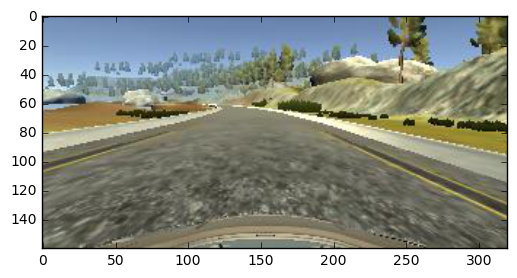

In [2]:
plt.imshow(plt.imread("./data/training/IMG/center_2016_12_01_13_41_15_788.jpg"))

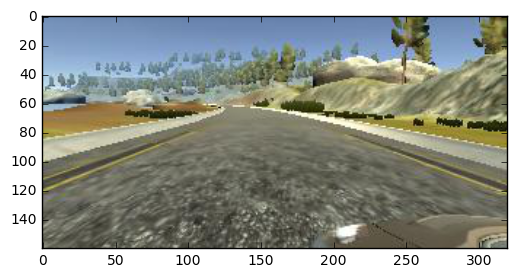

In [3]:
plt.imshow(plt.imread("./data/training/IMG/left_2016_12_01_13_41_15_788.jpg"))

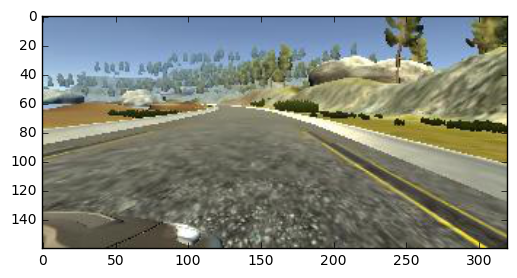

In [4]:
plt.imshow(plt.imread("./data/training/IMG/right_2016_12_01_13_41_15_788.jpg"))

## Deep Learning

To solve this problem of going from images to steering angle, we will be using deep learning. Specifically, convolutional neural networks and even more specifically a model developed at NVIDIA called PilotNet. Take a look at the paper in the sources. We will define this model using Keras:

In [5]:
def pilot_net():
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1., input_shape = (66, 200, 3)))
    model.add(Conv2D(24, (5, 5), strides=(2,2), padding="valid", kernel_initializer="he_normal"))
    model.add(ELU())
    model.add(Conv2D(36, (5, 5), strides=(2,2), padding="valid", kernel_initializer="he_normal"))
    model.add(ELU())
    model.add(Conv2D(48, (5, 5), strides=(2,2), padding="valid", kernel_initializer="he_normal"))
    model.add(ELU())
    model.add(Conv2D(64, (3, 3), strides=(1,1), padding="valid", kernel_initializer="he_normal"))
    model.add(ELU())
    model.add(Conv2D(64, (3, 3), strides=(1,1), padding="valid", kernel_initializer="he_normal"))
    model.add(ELU())
    model.add(Flatten())
    model.add(Dense(1164, kernel_initializer="he_normal"))
    model.add(ELU())
    model.add(Dense(100, kernel_initializer="he_normal"))
    model.add(ELU())
    model.add(Dense(50, kernel_initializer="he_normal"))
    model.add(ELU())
    model.add(Dense(10, kernel_initializer="he_normal"))
    model.add(ELU())
    model.add(Dense(1, kernel_initializer="he_normal"))
    model.compile(optimizer="adam", loss="mse", metrics=['mse'])
    return model

So now that we have a model we have defined, we need to train it. Since testing will take place in the simulator, we will use all our data for training. Also, in order to avoid loading all the images into memory at once, we will leverage Keras' ability to train using a generator.

In [6]:
def process_line(line_data, base_dir = "./data/training/"):
    # randomly choose a camera angle
    i_lrc = np.random.randint(3)
    # we have the adjust the angle for the left and right images because steering angle relative to center image.
    adj_value = 0.25
    if (i_lrc == 0):
        path_file = base_dir + line_data['left'][0].strip()
        shift_ang = adj_value
    elif (i_lrc == 1):
        path_file = base_dir + line_data['center'][0].strip()
        shift_ang = 0
    else:
        path_file = base_dir + line_data['right'][0].strip()
        shift_ang = adj_value * -1
    y_steer = line_data['steering'][0] + shift_ang
    image = cv2.imread(path_file)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = preprocessImage(image)
    image = np.array(image)
    return image, y_steer

def preprocessImage(image, new_size_col=200, new_size_row=66):
    shape = image.shape
    # remove the sky from the image
    image = image[math.floor(shape[0]/5):shape[0]-25, 0:shape[1]]
    # resize to the appropriate size for the network
    image = cv2.resize(image,(new_size_col,new_size_row), interpolation=cv2.INTER_AREA)    
    return image

def batch_generator(data, batch_size = 32):
    
    batch_images = np.zeros((batch_size, 66, 200, 3))
    batch_steering = np.zeros(batch_size)
    # always generate images
    while 1:
        for i_batch in range(batch_size):
            i_line = np.random.randint(len(data))
            line_data = data.iloc[[i_line]].reset_index()
            x,y = process_line(line_data)
            batch_images[i_batch] = x
            batch_steering[i_batch] = y
        yield batch_images, batch_steering
        
        
def train_model(model, steps_per_epoch, nb_epoch):
    data = pd.read_csv("./data/training/driving_log.csv")
    train_generator = batch_generator(data)
    model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=nb_epoch,
        verbose=1)
    model.save_weights("./data/models/first/model.h5")
    model_json = model.to_json()
    with open("./data/models/first/model.json", 'w') as outfile:
        outfile.write(model_json)

In [7]:
# just a very small amount of data to make sure working. for a real example do more like 8-ish epochs of all the data.
train_model(pilot_net(), 2, 1)

Epoch 1/1
2/2 [==============================] - 1s - loss: 1.9225 - mean_squared_error: 1.9225     


## Done...right?

Let's take a look at how well this model does. I mean it's deep learning, so we should be done, right? You can run a saved version of this model in Udacity's simulator by running "python drive.py first/model_0.json" from the data/models folder.

What you will discover is that it does very poorly...crashing immediately. 

This is where deep learning becomes interesting. We tried a model and it didn't perform well, so how do we make it better? A very popular approach is to throw more data at it. Now, diagnosing and improving a deep net is an entire talk (if not much much more) in itself. I don't want to spend much time on that subject other than to say that getting more data can help.

But what kind of data and how? Obviously, getting more of the same data we already have probably won't help as much. So how do we get enough data for this network to generalize well enough to drive around the track?

One approach might be driving the simulator a lot more and collecting data. We could drive around the track always hugging the left edge to get more data and maybe drive in zig-zags to get more data across the entire track. This would probably work, but could be very time consuming.

What I would like to propose is data augmentation. That is taking the data we have and augmenting or tweaking it in different ways to make lots of slightly different images from a single image. This method can be very powerful and helps our model generalize better without having to actually collect more data.

## Data Augmentation


First, one thing we can do is randomly change the brightness of the images. This will help the model better generalize the shadier or sunnier parts of the track. We will do this by converting the HSV color because the V is basically the brighness of the image. We will randomly perturb the V value and then convert back to RGB for the model.

In [8]:
def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

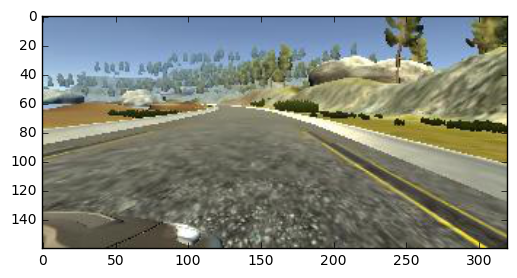

In [9]:
image = cv2.imread("./data/training/IMG/right_2016_12_01_13_41_15_788.jpg")
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
aug_image = augment_brightness_camera_images(image)
plt.imshow(image)

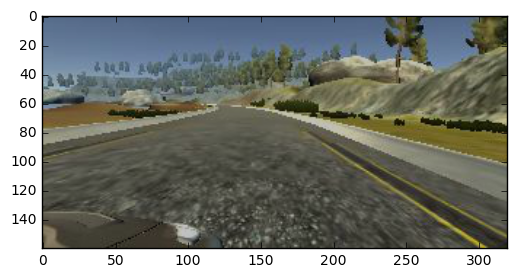

In [10]:
plt.imshow(aug_image)

Next, we can randomly apply and affine transformation to the image. Basically, we are shifting the image slightly so that it looks like a different angle the car is taking. Thus, we also have to adjust the steering angle. You can see in the code below that I change the steering angle by .004 for every shift in x. This parameter took time to tune by seeing how changes played out on the track.

In [11]:
def transform_image(image,steer):
    tr_x = np.random.normal(0, 10, 1)[0]
    tr_y = np.random.normal(0, 10, 1)[0]
    steer_ang = steer + (tr_x * 0.004)
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    image_tr = cv2.warpAffine(image,Trans_M,(image.shape[1], image.shape[0]))
    return image_tr,steer_ang

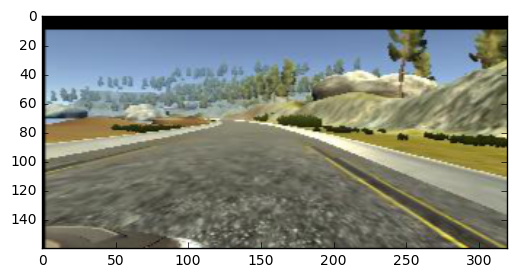

In [12]:
aug_image, _ = transform_image(image, 0)
plt.imshow(aug_image)

We can now add these to our process line function. We also add one last augmentation where with 50-50 probability, we flip the image around the y-axis and take the negative of the steering angle. Basically realizing that every image can be flipped as long as we make that simple adjustment to the steering angle.

In [233]:
def process_line(line_data, base_dir="./data/training/", verbose=False):
    i_lrc = np.random.randint(3)
    adj_value = 0.25
    if (i_lrc == 0):
        path_file = base_dir + line_data['left'][0].strip()
        shift_ang = adj_value
    if (i_lrc == 1):
        path_file = base_dir + line_data['center'][0].strip()
        shift_ang = 0.
    if (i_lrc == 2):
        path_file = base_dir + line_data['right'][0].strip()
        shift_ang = adj_value * -1
    if verbose:
        print(path_file)
    y_steer = line_data['steering'][0] + shift_ang
    image = cv2.imread(path_file)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    ## affine transformation
    image,y_steer = transform_image(image,y_steer)
    ## augment brightness
    image = augment_brightness_camera_images(image)
    image = preprocessImage(image)
    image = np.array(image)
    ## randomly flip around y-axis
    ind_flip = np.random.randint(2)
    if ind_flip==0:
        image = cv2.flip(image,1)
        y_steer = -y_steer
    
    return image,y_steer

We will also make a few simple changes to our batch_generator. In our data we have a bias towards driving straight (that is having a steering angle close to zero - see below). To account for this when we see a steering angle between -.1 and .1, we only keep it with a certain probability - basically trying to downsample these straight line images. In fact, in our training we actually do this with a decaying probability. Thus, during our first epoch we highly favor non-straight images, but with each additional epoch we allow more and more straight images into the training. This seemed to help the network to not get stuck early in a straight-driving mode.

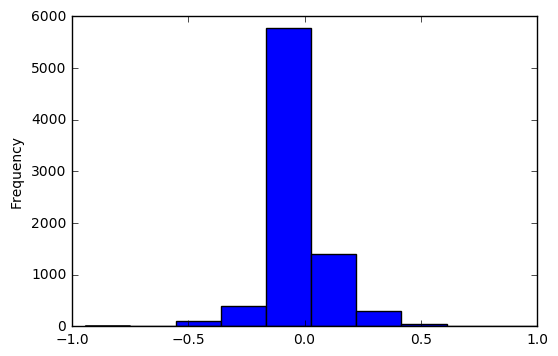

In [14]:
data = pd.read_csv("./data/training/driving_log.csv")
data.steering.plot(kind='hist')

In [15]:
def batch_generator(data,batch_size = 32):
    
    batch_images = np.zeros((batch_size, 66, 200, 3))
    batch_steering = np.zeros(batch_size)
    while 1:
        for i_batch in range(batch_size):
            i_line = np.random.randint(len(data))
            line_data = data.iloc[[i_line]].reset_index()
            
            keep_pr = 0
            while keep_pr == 0:
                x,y = process_line(line_data)
                if abs(y)<.1:
                    pr_val = np.random.uniform()
                    if pr_val>pr_threshold:
                        keep_pr = 1
                else:
                    keep_pr = 1
            
            batch_images[i_batch] = x
            batch_steering[i_batch] = y
        yield batch_images, batch_steering
        
def train_model(model, steps_per_epoch=100, nb_epoch=8, batch_size=256,
               nb_val_samples=10):
    
    data = pd.read_csv("./data/training/driving_log.csv")
    train_generator = batch_generator(data, batch_size)
    validation_generator = batch_generator(data, batch_size)
    global pr_threshold

    for i in range(nb_epoch):
        pr_threshold = (1/(i+1))
        print(pr_threshold)
        model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=1,
                 verbose=1, validation_data=validation_generator, validation_steps=nb_val_samples)
        model.save_weights("./data/models/final/model_"+str(i)+".h5")
        model_json = model.to_json()
        with open("./data/models/final/model_"+str(i)+".json", 'w') as outfile:
            outfile.write(model_json)

In [16]:
## just a small example to test. Saved actual model as data/models/final/model_working.json
train_model(pilot_net(), 2, 3, 32, 1)

1.0
Epoch 1/1
2/2 [==============================] - 1s - loss: 2.2038 - mean_squared_error: 2.2038 - val_loss: 0.4751 - val_mean_squared_error: 0.4751
0.5
Epoch 1/1
2/2 [==============================] - 1s - loss: 0.6963 - mean_squared_error: 0.6963 - val_loss: 0.2286 - val_mean_squared_error: 0.2286
0.3333333333333333
Epoch 1/1
2/2 [==============================] - 0s - loss: 0.1664 - mean_squared_error: 0.1664 - val_loss: 0.1967 - val_mean_squared_error: 0.1967


## Augmented Model Results

We can now see how well this augmented model works by running "python drive.py final/model_working.json" in the data/models folder. This model performs much better and can make it around the entire track!

## Visualization of Activation Maps

In [304]:
# 2, 4, 6, 8, 10
from keras.models import model_from_json
from keras.layers import Conv2DTranspose
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

In [321]:
data = pd.read_csv("./data/training/driving_log.csv")
line_data = data.iloc[[0]].reset_index()
x, _ = process_line(line_data, verbose=True)
x = np.expand_dims(x, axis=0)

./data/training/IMG/center_2016_12_01_13_30_48_287.jpg


In [322]:
def get_model():
    with open('./data/models/final/model_working.json') as json_data:
        d = json_data.readline()
    final_model = model_from_json(d)
    final_model.load_weights("./data/models/final/model_working.h5")
    return final_model

def get_activations(final_model, layer, x):
    final_model.outputs = [final_model.layers[layer].output]
    y_pred = final_model.predict(x)
    return y_pred
    
def get_array_activations(x, layers=[2,4,6,8,10]):
    activations = []
    for layer in layers:
        final_model = get_model()
        activations.append(get_activations(final_model, layer, x))
    return activations

def get_mean_activations(activations):
    means = []
    for activation in activations:
        means.append(np.mean(activation, axis=3)[0,:,:])
    return means

def resize(means):
    resize_x = 0
    resize_y = 0
    resized = []
    previous_product = 0
    for i in reversed(range(len(means))):
        if i == 0:
            previous_product = cv2.resize(previous_product, (200, 66), interpolation = cv2.INTER_CUBIC)
            max_v = np.max(previous_product)
            min_v = np.min(previous_product)
            previous_product = (previous_product - min_v) / (max_v - min_v)
            break
        m = means[i]
        m_next = means[i-1]
        shape = m_next.shape
        resize_x = shape[1]
        resize_y = shape[0]
        if i == len(means) - 1:
            up_m = cv2.resize(m, (resize_x, resize_y), interpolation = cv2.INTER_CUBIC)
            previous_product = up_m * m_next
        else:
            up_prev_product = cv2.resize(previous_product, (resize_x, resize_y), interpolation = cv2.INTER_CUBIC)
            previous_product = up_prev_product * m_next
    return previous_product

In [323]:
activations = get_array_activations(x)

In [324]:
means = get_mean_activations(activations)

In [325]:
resized = resize(means)

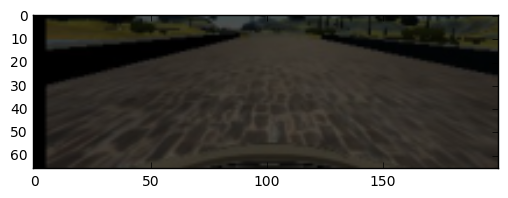

In [326]:
x_mask = np.zeros((66, 200, 3))
x_mask[:,:,1] = resized * 255
x_mask[:,:,0] = 80
x_image = x[0,:,:,:]
x_image = cv2.cvtColor(x_image,cv2.COLOR_RGB2BGR)
x_mask = x_mask.astype('uint8')
combined = cv2.addWeighted(x_image,.2,x_mask,.8,0)
combined = cv2.cvtColor(combined,cv2.COLOR_BGR2RGB)
x_image = cv2.cvtColor(x_image,cv2.COLOR_BGR2RGB)
plt.imshow(x_image)

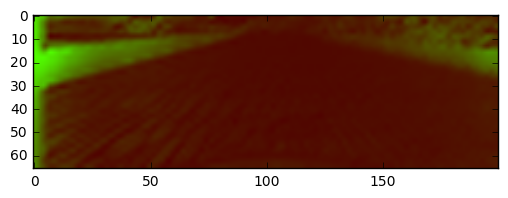

In [327]:
plt.imshow(x_mask)

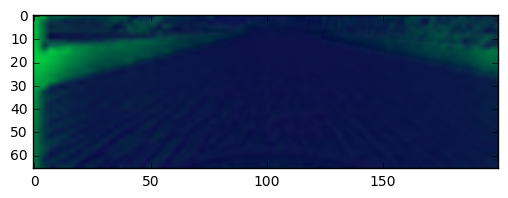

In [328]:
plt.imshow(combined)